In [49]:
import numpy as np
import matplotlib.pyplot as plt
sig = np.load('tests/testing_data/signal.npy')
sig.shape
%matplotlib inline

In [ ]:
from monai.transforms import SignalResample
from monai.transforms import SignalRandShift
from monai.transforms import Compose

In [ ]:
tfs = Compose([SignalResample(method='polynomial',current_sample_rate=500,target_sample_rate=250),
               SignalRandShift()])

In [ ]:
tfs(sig).shape

In [50]:
from monai.transforms import RandomizableTransform

class RandShiftIntensity100(RandomizableTransform):
    def randomize(self):
        super().randomize(None)
        self._offset = self.R.uniform(low=0, high=100)

    def __call__(self, img):
        self.randomize()
        if not self._do_transform:
            return img
        return img + self._offset

transform = RandShiftIntensity100()
transform.set_random_state()
print(transform(10))

99.99837479796943


In [93]:
import numpy as np
from typing import Sequence, Optional, Union, Any
from monai.transforms.transform import Transform
from monai.utils import optional_import
from monai.utils.enums import TransformBackends

zoom, has_zoom = optional_import("scipy.ndimage", name="zoom")
resample_poly, has_resample_poly = optional_import("scipy.signal", name="resample_poly")
fft, has_resample_fft = optional_import("scipy.signal", name="resample")
shift, has_shift = optional_import("scipy.ndimage.interpolation", name="shift")

assert has_zoom
assert has_resample_poly
assert has_resample_poly
assert has_resample_fft
assert has_shift

class SignalRandShift(RandomizableTransform):
    """
    Apply a random shift on a signal
    """
    backend = [TransformBackends.NUMPY]
        
    def __init__(
        self, 
        mode: str='wrap',
        filling: Optional[Union[np.ndarray,Any]] = 0.0,
        v: float = 1.0, 
        boundaries: Optional[Union[np.ndarray,Any]] = [-1.0,1,0],
        *args, 
        **kwargs
    ) -> None:
        super(SignalRandShift,self).__init__()
        """
        Args:
            mode: define how the extension of the input array is done beyond its boundaries, see for more details for possible values
            https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html
            filling: value to fill past edges of input if mode is ‘constant’. Default is 0.0. see for mode details
            https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html
            v: scaling factor
            boundaries: range of the signal shift, taken randomly in the defined range. Defaults to ``[-1.0, 1.0]``
        """    
        
        self.filling = filling
        self.mode = mode
        self.v = v
        self.boundaries = boundaries
        
    def randomize(self):
        super().randomize(None)
        self.magnitude = self.R.uniform(low=self.boundaries[0],high=self.boundaries[1])
        
    def __call__(self, signal: np.ndarray) -> np.ndarray:
        """
        Args:
            signal: input 1 dimension signal to be resampled
        """
        self.randomize()
        if len(signal.shape) == 1:
            signal = np.expand_dims(signal, axis=0)  
        length = signal.shape[1]
        factor = self.v * self.magnitude
        shift_idx = round(factor * length)
        signal = shift(input=signal,
                       mode=self.mode,
                       shift=shift_idx, 
                       cval=self.filling)
        
        return signal

In [97]:
t = SignalRandShift(boundaries=[-.5,.5])

In [98]:
t(sig)

array([[ 0.1941886 ,  0.19580679,  0.19585417, ...,  0.19525363,
         0.19386567,  0.1941886 ],
       [-0.11469602, -0.11522655, -0.11479264, ..., -0.11599481,
        -0.1157399 , -0.11469602],
       [-0.02791589, -0.02847878, -0.02884416, ..., -0.02754898,
        -0.02691086, -0.02791589],
       [-0.09093187, -0.0918969 , -0.09214413, ..., -0.09110427,
        -0.09017903, -0.09093187],
       [ 0.03716419,  0.03707249,  0.03664558, ...,  0.03800022,
         0.03826782,  0.03716419],
       [ 0.1941886 ,  0.19580679,  0.19585417, ...,  0.19525363,
         0.19386567,  0.1941886 ]], dtype=float32)

In [99]:
t.boundaries

[-0.5, 0.5]

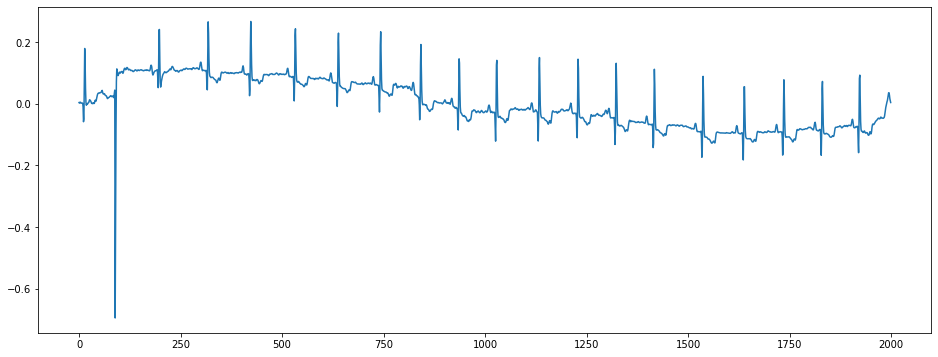

In [103]:
plt.figure(figsize=(16,6))
plt.plot(t(sig)[0,:])